## Suppl. Fig. 5 panel C tenary plots


In [1]:
import math, os, sys
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import ternary
from matplotlib.path import Path as mplPath
from matplotlib.patches import PathPatch
import matplotlib.lines as mlines

plt.rcParams["pdf.fonttype"] = 42

script_path = Path.cwd().parent.parent.parent.parent / "script"
data_path = Path.cwd().parent.parent.parent.parent / "data"
sys.path.append(str(script_path))
from utils.label_processing import attach_annotations

save_path = Path.cwd() / "output"
if not os.path.exists(save_path):
    os.makedirs(save_path)

## load data

In [2]:
%store -r timestamp
print(f"Timestamp: {timestamp}")   

Timestamp: 2023-10-21-imp5-for-figures


In [3]:
# define files to load
enrichment_dir = Path.cwd().parent.parent.parent / "enrichment"
enrichment_csv_path = enrichment_dir / "output" / "enrichment_and_volcano_tables" / f'{timestamp}_enrichment_table_NOC_prop.csv'

try:
    # load the file
    enrichments = pd.read_csv(enrichment_csv_path, header=[0, 1], index_col=0)
except FileNotFoundError:
    print(f"File {enrichment_csv_path} not found.\nPlease run the enrichment analysis first or specify the correct timestamp, current value is {timestamp}")
except pd.errors.ParserError:
    print(f"There was an error parsing the CSV file at {enrichment_csv_path}.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

In [4]:
# attach labels
labels_csv = Path.cwd().parent.parent.parent / "Fig2" / "panel_C" / "output" / f"{timestamp}_graph-based_annotations.csv"

lookup_table = pd.read_csv(labels_csv)
to_df = enrichments["metadata"].copy()
list_of_cols_to_add = reversed(["cluster_annotation", "Graph-based_localization_annotation", "consensus_graph_annnotation"])
for c in list_of_cols_to_add:
    new_col_data = attach_annotations(from_df=lookup_table, to_df=to_df, anno_col=c, from_on="Majority protein IDs", to_on="Majority protein IDs")
    enrichments.insert(2, ("metadata", c), new_col_data)
    #enrichments[("metadata", c)] = new_col_data


In [5]:
df = enrichments.droplevel(0, axis=1)

## group proteins
three groups:
- cytosolic
- nucleus
- membrane-bound compartments: mitochondria, peroxisomes, ER, ERGIC, Golgi, trans-Golgi, early endosome endosomes, recycling endosome, plasma membrane, lysosomes

In [6]:
labels_used_to_group = "consensus_graph_annnotation" # other options: "cluster_annotation" "Graph-based_localization_annotation", "consensus_graph_annnotation"

In [7]:
# check labels
df[labels_used_to_group].unique()

array(['nucleus', 'Golgi', 'cytosol', 'trans-Golgi', 'early_endosome',
       'stress_granule', 'unclassified', 'centrosome', 'ER',
       'recycling_endosome', 'plasma_membrane', 'mitochondrion',
       'lysosome', 'actin_cytoskeleton', 'translation', 'nucleolus',
       '14-3-3_scaffold', 'peroxisome', 'p-body', 'ERGIC', 'proteasome'],
      dtype=object)

In [8]:
# list of membrane bound compartment names
mbc = ['mitochondrion', 'peroxisome', 'ER', 'ERGIC', 'Golgi', 'trans-Golgi', 
       'early_endosome', 'recycling_endosome', 'plasma_membrane', 'lysosome']
# make sure there is no typo
assert all([x in df[labels_used_to_group].unique() for x in mbc])

In [9]:
# group proteins
df["group"] = df[labels_used_to_group].apply(lambda x: "membrane_bound_compartment" if x in mbc else 
                                           "cytosol" if x == "cytosol" else 
                                           "nucleus" if x == "nucleus" else
                                           "unclassified" if x=="unclassified" else "other")

In [10]:
# check groups
df["group"].unique()

array(['nucleus', 'membrane_bound_compartment', 'cytosol', 'other',
       'unclassified'], dtype=object)

## ternary plots

In [11]:
# ternary plot parameters
scale = 1 
pointsize = 80

### ternary: scatterplot

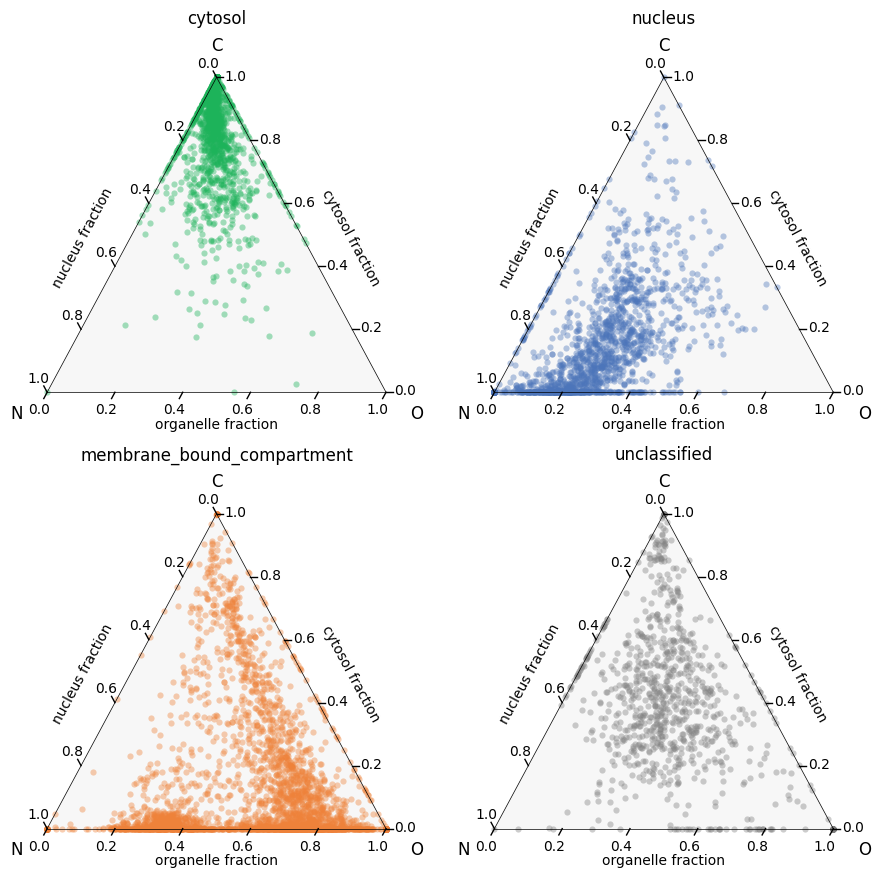

In [12]:
# plot the ternary plot
nrows = 2
ncols = 2
fig, axs = plt.subplots(nrows=2, ncols=2)  
fig.set_size_inches(10, 10)  # Set the figure size to letter size (8.5 x 11 inches)
fig.subplots_adjust(left=0.08, bottom=0.08)  # set the left and bottom margin for x and y axis labels

groups = ["cytosol", "nucleus", "membrane_bound_compartment", "unclassified"]
colors = ["#1DB35A", "#4C75BA", "#EE823A", "grey"]

idx = 0
for r in range(nrows):
    for c in range(ncols):
        group = groups[idx]
        tmp_df = df[df["group"]==group]
        points = list(zip(tmp_df["NOC_organelle"], tmp_df["NOC_cytosol"], tmp_df["NOC_nuclear"]))

        tax = ternary.TernaryAxesSubplot(ax=axs[r,c], scale=scale)
        tax.boundary(linewidth=0.5)
        tax.scatter(points, marker='.', color=colors[idx], label=group, alpha=0.4, s=pointsize, linewidths=0, edgecolors=None)
        tax.left_axis_label("nucleus fraction", fontsize=10, offset = 0.15)
        tax.right_axis_label("cytosol fraction", fontsize=10, offset = 0.15)
        tax.bottom_axis_label("organelle fraction", fontsize=10, offset = 0)
        tax.ticks(axis='lbr', linewidth=1, multiple=0.2, tick_formats="%.1f", offset=0.02)
        tax.right_corner_label("O", fontsize=12, offset=0.15, va='top')
        tax.top_corner_label("C", fontsize=12, offset=0.2)
        tax.left_corner_label("N", fontsize=12, offset=0.15, va='top')
        tax.clear_matplotlib_ticks()
        tax.set_title(group, fontsize=12, x=0.5, y=1.09)

        for spine in axs[r,c].spines.values():
            spine.set_visible(False)
        
        idx += 1

# save figure
fig.savefig(save_path / f"{timestamp}_ternery_subplots.pdf", dpi=300, bbox_inches='tight', format="pdf")


### tenary: percentile contour lines

preprocess tenary data

In [13]:
cyto_df = df[df["group"] == "cytosol"]
nuc_df = df[df["group"] == "nucleus"]
mbc_df = df[df["group"] == "membrane_bound_compartment"]
unclassified_df = df[df["group"] == "unclassified"]

cyto_points = list(zip(cyto_df["NOC_organelle"], cyto_df["NOC_cytosol"], cyto_df["NOC_nuclear"]))
nuc_points = list(zip(nuc_df["NOC_organelle"], nuc_df["NOC_cytosol"], nuc_df["NOC_nuclear"]))
mbc_points = list(zip(mbc_df["NOC_organelle"], mbc_df["NOC_cytosol"], mbc_df["NOC_nuclear"]))
unclassified_points = list(zip(unclassified_df["NOC_organelle"], unclassified_df["NOC_cytosol"], unclassified_df["NOC_nuclear"]))

compute cartesian coordinates (for contour lines estimation)

In [14]:
def ternary_to_cartesian(ternary_points):
    '''Convert ternary points to cartesian points'''
    cartesian_points = []
    for a, b, c in ternary_points:
        x = 0.5 * (2*b + c)
        y = (math.sqrt(3) / 2) * c
        cartesian_points.append((x, y))
    return cartesian_points

cyto_tenary_in_cart = ternary_to_cartesian(list(zip(cyto_df["NOC_nuclear"], cyto_df["NOC_organelle"], cyto_df["NOC_cytosol"])))
nuc_tenary_in_car = ternary_to_cartesian(list(zip(nuc_df["NOC_nuclear"], nuc_df["NOC_organelle"], nuc_df["NOC_cytosol"])))
mbc_tenary_in_car = ternary_to_cartesian(list(zip(mbc_df["NOC_nuclear"], mbc_df["NOC_organelle"], mbc_df["NOC_cytosol"])))
unclassified_tenary_in_car = ternary_to_cartesian(list(zip(unclassified_df["NOC_nuclear"], unclassified_df["NOC_organelle"], unclassified_df["NOC_cytosol"])))

put cartesian coords in a dataframe for sns

In [15]:
x = list(np.array(cyto_tenary_in_cart)[:, 0]) + list(np.array(nuc_tenary_in_car)[:, 0]) + list(np.array(mbc_tenary_in_car)[:, 0]) + list(np.array(unclassified_tenary_in_car)[:, 0])
y = list(np.array(cyto_tenary_in_cart)[:, 1]) + list(np.array(nuc_tenary_in_car)[:, 1]) + list(np.array(mbc_tenary_in_car)[:, 1]) + list(np.array(unclassified_tenary_in_car)[:, 1])
group = ["cytosol"]*len(cyto_df) + ["nucleus"]*len(nuc_df) + ["membrane_bound_compartment"]*len(mbc_df) + ["unclassified"]*len(unclassified_df)
kde_df = pd.DataFrame({"x": x, "y": y, "group": group})

visually verify cartesian coordinates

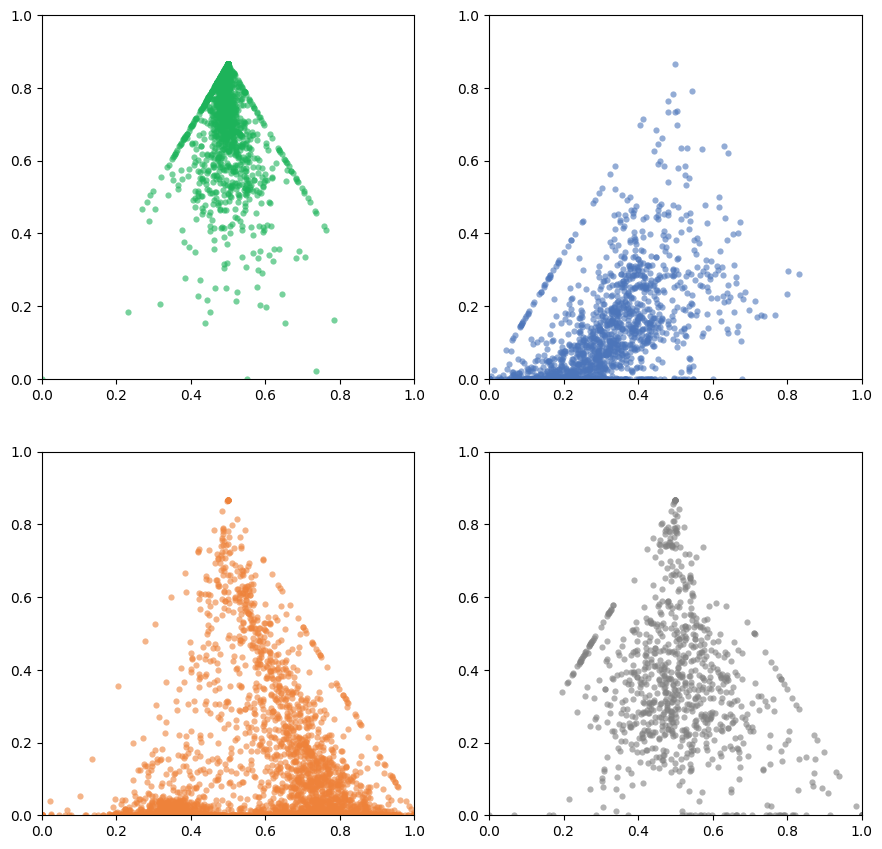

In [16]:
# plot the ternary plot
nrows = 2
ncols = 2
fig, axs = plt.subplots(nrows=2, ncols=2)  
fig.set_size_inches(10, 10)  # set the figure size to letter size (8.5 x 11 inches)
fig.subplots_adjust(left=0.08, bottom=0.08)  # set the left and bottom margin for x and y axis labels

groups = ["cytosol", "nucleus", "membrane_bound_compartment", "unclassified"]
colors = ["#1DB35A", "#4C75BA", "#EE823A", "grey"]

idx = 0
for r in range(nrows):
    for c in range(ncols):
        group = groups[idx]
        tmp_df = kde_df[kde_df["group"]==group]
        axs[r,c].scatter(tmp_df["x"], tmp_df["y"], marker='.', color=colors[idx], label=group, alpha=0.6, s=pointsize, linewidths=0, edgecolors=None)
        axs[r,c].set_ylim(0, 1)
        axs[r,c].set_xlim(0, 1)
        idx += 1

draw the percentile contour lines, aka iso-proportion level lines  
setting thres to 0.2 and levels to 9, means that first line is drawn at 20%, and draw 9 lines in total.

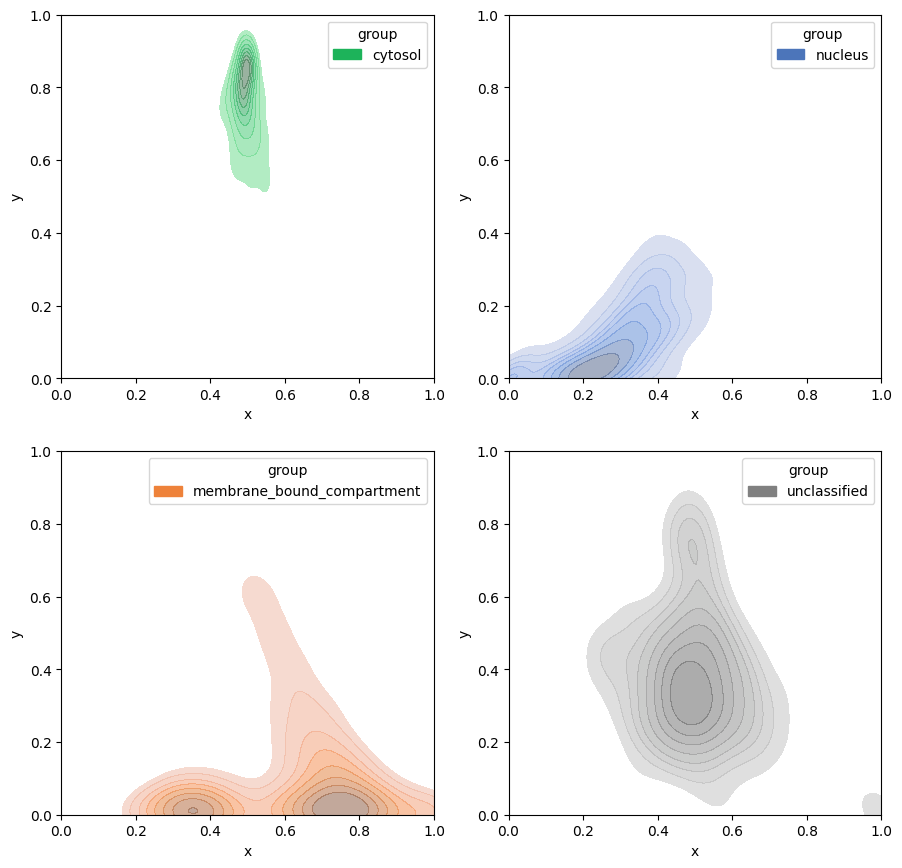

In [17]:
thres = 0.2  # lowest iso-proportion level at which to draw a contour line
levels = 9  # number of iso-proportion levels to draw

nrows = 2
ncols = 2
fig, axs = plt.subplots(nrows=2, ncols=2)  
fig.set_size_inches(10, 10)  # set the figure size to letter size (8.5 x 11 inches)
fig.subplots_adjust(left=0.08, bottom=0.08)  # set the left and bottom margin for x and y axis labels

groups = ["cytosol", "nucleus", "membrane_bound_compartment", "unclassified"]
colors = ["#1DB35A", "#4C75BA", "#EE823A", "grey"]

idx = 0
for r in range(nrows):
    for c in range(ncols):
        group = groups[idx]
        tmp_df = kde_df[kde_df["group"] == group]
        sns.kdeplot(data=tmp_df, x="x", y="y", hue="group",
                    fill=True, levels = levels, thresh=thres, alpha=0.5, palette=[colors[idx]],
                    ax = axs[r,c])
        axs[r,c].set_ylim(0, 1)
        axs[r,c].set_xlim(0, 1)
        idx += 1

fig.savefig(save_path / f"{timestamp}_percentile_contour_subplots.pdf", dpi=300, bbox_inches='tight', format="pdf")

overlay

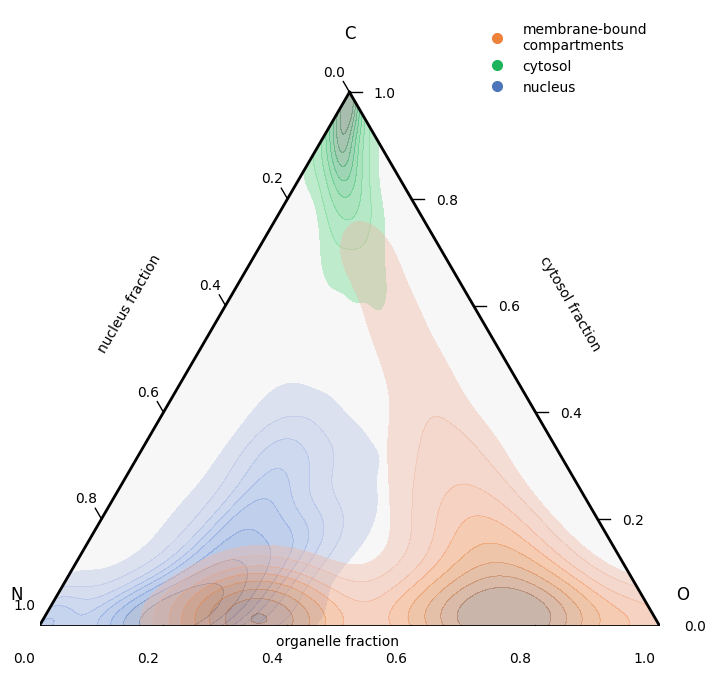

In [18]:
# create a matplotlib figure and axes
fig, ax = plt.subplots(figsize=(8, 8))

# generate the Seaborn KDE plot
groups = ["cytosol", "nucleus", "membrane_bound_compartment"]
colors = ["#1DB35A", "#4C75BA", "#EE823A"]

idx = 0
for r in range(len(groups)):
        group = groups[idx]
        tmp_df = kde_df[kde_df["group"] == group]
        sns.kdeplot(data=tmp_df, x="x", y="y", hue="group", ax = ax,
                    fill=True, levels = levels, thresh=thres, alpha=0.4, palette=[colors[idx]])
        idx += 1

# define ternary plot boundaries as a polygon
ternary_boundary = mplPath([(0, 0), (1, 0), (0.5, 0.866)])  # These are the vertices of the triangle, the top point (0.5, 0.866) is simply derived from properties of an equilateral triangle
patch = PathPatch(ternary_boundary, transform=ax.transData)
# apply the clipping path to the KDE plot
for collection in ax.collections:
    collection.set_clip_path(patch)

# turn off x and y axis
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_yticks([])
ax.set_xticks([])
ax.set_ylabel("")
ax.set_xlabel("")
ax.set_title("")
ax.set_frame_on(False)

ax.set_ylim(0, 1)
ax.set_xlim(0, 1)

# overlay the Ternary plot
tax = ternary.TernaryAxesSubplot(ax=ax, scale=1)
tax.left_axis_label("nucleus fraction", fontsize=10, offset = 0.15)
tax.right_axis_label("cytosol fraction", fontsize=10, offset = 0.15)
tax.bottom_axis_label("organelle fraction", fontsize=10, offset = 0.075)
tax.ticks(axis='lbr', linewidth=1, multiple=0.2, tick_formats="%.1f", offset=0.02)
tax.right_corner_label("O", fontsize=12, offset=0.15, va='top')
tax.top_corner_label("C", fontsize=12, offset=0.1)
tax.left_corner_label("N", fontsize=12, offset=0.15, va='top')
#tax.get_axes().set_position([0.1, 21.1, 0.8, 0.8])  # Adjust these values as needed
tax.boundary(linewidth=2.0)

ax.set_ylim(0, 1)
ax.set_xlim(0, 1)

legend_handles = [
            mlines.Line2D([], [], color='#EE823A', marker='.', linestyle='None', markersize=14, label='membrane-bound\ncompartments', alpha=1),
            mlines.Line2D([], [], color='#1DB35A', marker='.', linestyle='None', markersize=14, label='cytosol', alpha=1),
            mlines.Line2D([], [], color='#4C75BA', marker='.', linestyle='None', markersize=14, label='nucleus', alpha=1)
        ]
tax.legend(handles = legend_handles, fontsize=10, loc='upper right', title = "", bbox_to_anchor=(1, 1), frameon=False)